In [5]:
import math
import polars as pl
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

#Problem

[Article on multiple comparisons problem](https://www.graphpad.com/guides/prism/latest/statistics/beware_of_multiple_comparisons.htm)


<h1>Solutions</h1>

-   One-way analysis of variance with ad hoc tests
-   Multiple comparison adjustment


# Post hoc tests - Tukey’s Honestly Significant Difference (HSD)


-   An HSD is the minimum difference between two means that can be deemed statistically different, while keeping the experiment-wise alpha at 0.05.

-   Any two means separated by this amount or greater are significantly different from each other.

-   Any two means separated by less than this amount cannot be considered significantly different.


## HSD calculation


$$HSD = q\sqrt{\frac{\text{Mean Squares Within Groups}}{\text{Harmonic Mean}}} = q\sqrt{\frac{MS_W}{n_H}}$$

q - look up in a table based on df<sub>W</sub> and k. The harmonic mean is a geometric average of the number of subjects in each group.

**Remember that this is a post hoc comparison, therefore we have already calculated MSW, computed the ANOVA and found a statistically significant F ratio.**


<h1>Calculating the Harmonic Mean<h1>

$$n_H = \frac{k}{(\frac{1}{n_1} + \frac{1}{n_2} + ... + \frac{1}{n_k})}$$

Notice that this technique allows different numbers of subjects in each group.


<h1>Example. Ethanol and minutes of REM sleep at rats</h1>

Means:

-   0 g/kg - 79.28 minutes
-   1 g/kg - 61.54 minutes
-   2 g/kg - 47.92 minutes
-   3 g/kg - 32.76 minutes

Mean square within groups: $$MS_W = 92.68$$

Number of groups: $$k = 4$$

Total number of samples: $$n = 20$$

Degrees of freedom within groups: $$df_W = n-k = 20-4 = 16$$

According to the [q table](https://real-statistics.com/statistics-tables/studentized-range-q-table/): $$q(\alpha=0.05, df_W=16, k=4) = 4.046$$

Harmonic mean: $$n_H = 5$$

So:

$$HSD = 4.046 \sqrt{\frac{92.68}{5}} = 17.42$$

**Thus means as far or further apart than 17.42 represent a significant difference.**


| Comparisons                | Difference | p <= |
| -------------------------- | ---------- | ---- |
| 0g/kg 79.28 -> 1g/kg 61.54 | 17.74      | 0.05 |
| 0g/kg 79.28 -> 2g/kg 47.92 | 31.36      | 0.05 |
| 0g/kg 79.28 -> 3g/kg 32.76 | 46.52      | 0.05 |
| 1g/kg 61.54 -> 2g/kg 47.92 | 13.62      | n.s  |
| 1g/kg 61.54 -> 3g/kg 47.92 | 28.78      | 0.05 |
| 2g/kg 47.92 -> 3g/kg 32.76 | 15.16      | n.s  |


##Example calculation


Given data:


In [6]:
df_w = 16
q = 4.046
n_harmonic = 5

sleep_df = pl.DataFrame(
    {
        "group": [
            *(["0g/kg"] * 5),
            *(["1g/kg"] * 5),
            *(["2g/kg"] * 5),
            *(["4g/kg"] * 5),
        ],
        "rem": [
            88.6,
            73.2,
            91.4,
            68.0,
            75.2,
            63.0,
            53.9,
            69.2,
            50.1,
            71.5,
            44.9,
            59.5,
            40.2,
            56.3,
            38.7,
            31.0,
            39.6,
            45.3,
            25.5,
            22.7,
        ],
    }
)

### Manually


In [7]:
mean_square_within_groups = (
    sleep_df.group_by("group")
    .agg(
        pl.col("rem").mean().alias("group_mean")
    )  # here we calculate mean for each group
    .join(sleep_df, on="group")
    .with_columns(
        (pl.col("rem") - pl.col("group_mean")).alias("residual")
    )  # here we calculate residuals for each value
    .with_columns(
        (pl.col("residual") ** 2).sum().alias("SSw")
    )  # here we get Sum of squares for each group
    .with_columns((pl.col("SSw") / df_w).alias("MSw"))
)  # here we calculate Mean square within groups


print(mean_square_within_groups)
MSw = mean_square_within_groups.select(pl.col("MSw")).unique()[0].item()
print(f"\nMean square within groups = {MSw}")

shape: (20, 6)
┌───────┬────────────┬──────┬──────────┬──────────┬─────────┐
│ group ┆ group_mean ┆ rem  ┆ residual ┆ SSw      ┆ MSw     │
│ ---   ┆ ---        ┆ ---  ┆ ---      ┆ ---      ┆ ---     │
│ str   ┆ f64        ┆ f64  ┆ f64      ┆ f64      ┆ f64     │
╞═══════╪════════════╪══════╪══════════╪══════════╪═════════╡
│ 0g/kg ┆ 79.28      ┆ 88.6 ┆ 9.32     ┆ 1482.936 ┆ 92.6835 │
│ 0g/kg ┆ 79.28      ┆ 73.2 ┆ -6.08    ┆ 1482.936 ┆ 92.6835 │
│ 0g/kg ┆ 79.28      ┆ 91.4 ┆ 12.12    ┆ 1482.936 ┆ 92.6835 │
│ 0g/kg ┆ 79.28      ┆ 68.0 ┆ -11.28   ┆ 1482.936 ┆ 92.6835 │
│ …     ┆ …          ┆ …    ┆ …        ┆ …        ┆ …       │
│ 4g/kg ┆ 32.82      ┆ 39.6 ┆ 6.78     ┆ 1482.936 ┆ 92.6835 │
│ 4g/kg ┆ 32.82      ┆ 45.3 ┆ 12.48    ┆ 1482.936 ┆ 92.6835 │
│ 4g/kg ┆ 32.82      ┆ 25.5 ┆ -7.32    ┆ 1482.936 ┆ 92.6835 │
│ 4g/kg ┆ 32.82      ┆ 22.7 ┆ -10.12   ┆ 1482.936 ┆ 92.6835 │
└───────┴────────────┴──────┴──────────┴──────────┴─────────┘

Mean square within groups = 92.68350000000001


In [8]:
HSD = q * math.sqrt(MSw / n_harmonic)
print(f"HSD is {HSD}")

HSD is 17.419756865616698


Given this HSD value we can compare groups pairwise.

| Comparisons                | Difference | p <= |
| -------------------------- | ---------- | ---- |
| 0g/kg 79.28 -> 1g/kg 61.54 | 17.74      | 0.05 |
| 0g/kg 79.28 -> 2g/kg 47.92 | 31.36      | 0.05 |
| 0g/kg 79.28 -> 3g/kg 32.76 | 46.52      | 0.05 |
| 1g/kg 61.54 -> 2g/kg 47.92 | 13.62      | n.s  |
| 1g/kg 61.54 -> 3g/kg 47.92 | 28.78      | 0.05 |
| 2g/kg 47.92 -> 3g/kg 32.76 | 15.16      | n.s  |


### Automatically


<h4>ANOVA</h4>
Let's start with ANOVA test to check whether it is difference in means.

H<sub>0</sub>: There is no difference among group means.

H<sub>1</sub>: Means are not all equal.

<h4>Approach 1</h4>


In [9]:
model = smf.ols("rem ~ group", data=sleep_df.to_pandas()).fit()
anova_test = pl.DataFrame(sm.stats.anova_lm(model))
anova_test

df,sum_sq,mean_sq,F,PR(>F)
f64,f64,f64,f64,f64
3.0,5868.802,1956.267333,21.106964,0.000008
16.0,1482.936,92.6835,null,null


<h4>Approach 2</h4>

Here we need to turn categorical data into one-hot-encoding manually.


In [17]:
list(sleep_df.select("group").unique())

[shape: (4,)
 Series: 'group' [str]
 [
 	"2g/kg"
 	"1g/kg"
 	"0g/kg"
 	"4g/kg"
 ]]

In [25]:
# turning groups to one-hot-encoding format
ohe_df = sleep_df.to_dummies(columns=["group"])

# here REM is dependent variable
Y = ohe_df.select(pl.col("rem")).to_pandas()

# groups are independent variables
X = ohe_df.select(
    [col for col in ohe_df.columns if col.startswith("group_")]
).to_pandas()
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rem   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     21.11
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           8.29e-06
Time:                        16:17:08   Log-Likelihood:                -71.439
No. Observations:                  20   AIC:                             150.9
Df Residuals:                      16   BIC:                             154.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          44.3120      1.722     25.730      0.000      40.661      47.963
group_0g/kg    34.9680      3.753      9.316      0.000      27.011      42.925
group_1g/kg    17.2280      3.753      4.590      0.000       9.271      25.185
group_2g/kg     3.6080      3.753      0.961      0.351      -4.349      11.565
group_4g/kg   -11.4920      3.753     -3.062      0.007     -19.449      -3.535
==============================================================================
Omnibus:                       11.382   Durbin-Watson:                   2.847
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                2.211
Skew:                           0.161   Prob(JB):                        0.331
Kurtosis:                       1.403   Cond. No.                     1.53e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Both approaches present the same result - we can reject our null hypothesis.


Critical value: 3.24, Value: 21.11, p_value: 0.000


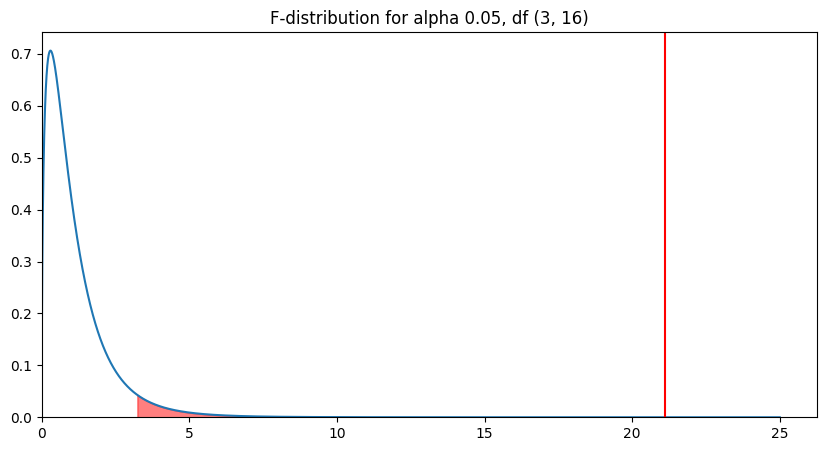

In [ ]:
f_statistic = 21.11
dfn, dfd = 3, 16  # degrees of freedom between and inside
x = np.arange(0, 25, 0.001)
critical_value = stats.f.ppf(0.95, dfn, dfd)
p_value = stats.f.sf(f_statistic, dfn, dfd)
print(
    f"Critical value: {critical_value:.2f}, Value: {f_statistic}, p_value: {p_value:.3f}"
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, stats.f.pdf(x, dfn, dfd))
ax.axvline(f_statistic, color="red")
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title(f"F-distribution for alpha 0.05, df {dfn, dfd}")
ax.fill_between(
    x, stats.f.pdf(x, dfn, dfd), where=x > critical_value, color="red", alpha=0.5
)
plt.show()

<h4>Tukey HSD test</h4>

Now we proceed with post-hoc Tukey HSD test.

H<sub>0</sub>: The means of the groups are equal.

H<sub>1</sub>: The means of the groups are **not** equal.


In [ ]:
tukey_test = pairwise_tukeyhsd(
    sleep_df.select(pl.col("rem")), sleep_df.select(pl.col("group"))
)
tukey_test.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0g/kg,1g/kg,-17.74,0.0452,-35.1602,-0.3198,True
0g/kg,2g/kg,-31.36,0.0005,-48.7802,-13.9398,True
0g/kg,4g/kg,-46.46,0.0,-63.8802,-29.0398,True
1g/kg,2g/kg,-13.62,0.1555,-31.0402,3.8002,False
1g/kg,4g/kg,-28.72,0.0012,-46.1402,-11.2998,True
2g/kg,4g/kg,-15.1,0.1017,-32.5202,2.3202,False


Displayed table shows p-values of all the comparisons with conclusions about hypotheses.

We can also display an interval plot.


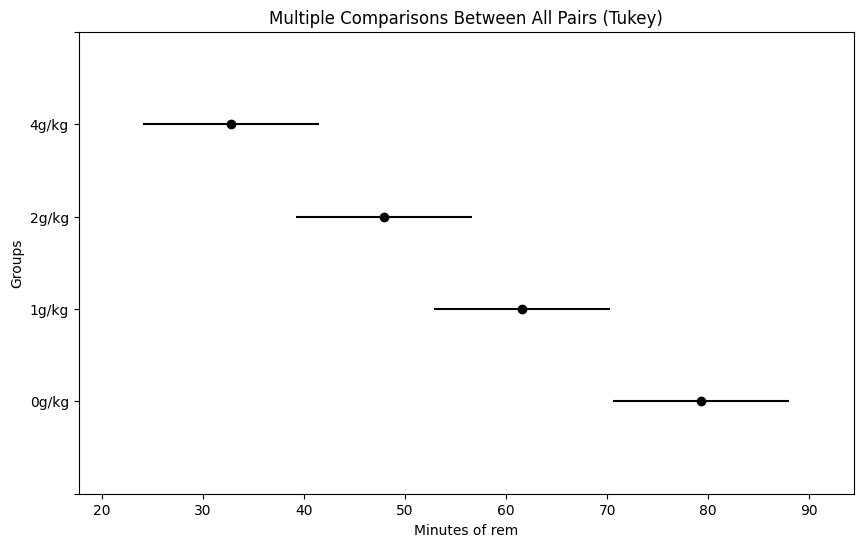

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
tukey_test.plot_simultaneous(xlabel=f"Minutes of rem", ylabel="Groups", ax=ax)
plt.show()

# Multiple comparison adjustment. Controlling for false discovery rates (FDR).

-   Bonferroni procedure - the most conservative

-   The False Discovery Rate, FDR (Benjamini and Hochberg) - the most commonly used


<h2>Bonferroni procedure</h2>

During _m_ independent statistic tests with $\alpha$ significance level, the probability of at least one false discovery should be

$$1 - (1-\alpha)^m < 0.05$$

$$\alpha = (1-0.05)^\frac{1}{m} \approx \frac{0.05}{m}$$

**Bonferroni correction:**

During _m_ independent statistic tests only those results are significant for which

$$p < \frac{0.05}{m}$$


<h2>Algorithm of FDR control.</h2>

1. Order tests by to p-value: $$p_1 < p_2 < … < p_m$$

2. For FDR control on $\alpha$ level (e.g. 0.05), we find $$j^* = max \cases j: p_j \le \frac{j}{m}\alpha $$

3. Differences are assumed to be significant for $$j = 1, ..., j^*$$
4. Differences are assumed not to be significant for $$j > j^*$$


<h1>Example table. Multiple comparisons on 10 tests.</h1>


In [ ]:
alpha = 0.05
tests_num = 10
bonferroni_threshold = alpha / tests_num

mc_table = pl.DataFrame(
    {
        "test_idx": np.arange(1, 11),
        "p_value": [0.001, 0.0055, 0.01, 0.015, 0.02, 0.04, 0.3, 0.5, 0.6, 0.8],
        "bonferroni_threshold": np.full(10, bonferroni_threshold),
    }
)
mc_table = mc_table.with_columns(
    (pl.col("test_idx") * alpha / tests_num).alias("fdr_threshold")
)
# here we compare p_values with bonferroni and fdr thresholds
mc_table = mc_table.with_columns(
    pl.when(pl.col("p_value") > pl.col("bonferroni_threshold"))
    .then("false")
    .otherwise("true")
    .alias("bonferroni_significant")
)
mc_table = mc_table.with_columns(
    pl.when(pl.col("p_value") > pl.col("fdr_threshold"))
    .then("false")
    .otherwise("true")
    .alias("fdr_significant")
)

mc_table

test_idx,p_value,bonferroni_threshold,fdr_threshold,bonferroni_significant,fdr_significant
i64,f64,f64,f64,str,str
1,0.001,0.005,0.005,"""true""","""true"""
2,0.0055,0.005,0.01,"""false""","""true"""
3,0.01,0.005,0.015,"""false""","""true"""
4,0.015,0.005,0.02,"""false""","""true"""
5,0.02,0.005,0.025,"""false""","""true"""
6,0.04,0.005,0.03,"""false""","""false"""
7,0.3,0.005,0.035,"""false""","""false"""
8,0.5,0.005,0.04,"""false""","""false"""
9,0.6,0.005,0.045,"""false""","""false"""
